In [1]:
import time
import os
import math
import tushare as ts
from datetime import datetime
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output

sys.path.append("../utils/")
import date_util
import token_util
import enter_util
import stock_util
import plot_util

In [2]:
trade_date = "20190830"
delta_price = 30.0

In [3]:
stock_list = pd.read_csv("../data_pulled/stock_list.csv")
stock_list.head()

,ts_code,name,price
0,000001.SZ,平安银行,14.145
1,000002.SZ,万科A,25.885
2,000004.SZ,国农科技,20.090
3,000005.SZ,世纪星源,3.135
4,000006.SZ,深振业A,5.360


### 测试两种进场的方式(最终选用第二种)

In [4]:
# 今世缘 603369.SH
# 韵达股份 002120.SZ
ts_code = "603369.SH"
# ts_code = "002120.SZ"

ROOT_PATH = os.path.join("..", "data_pulled")
ROOT_PATH = os.path.join(ROOT_PATH, "day")
data = pd.read_csv(os.path.join(ROOT_PATH, "{}.csv".format(ts_code)))

neg_macd_mean = data["macd"][data["macd"] < 0].mean()

neg_diff_mean = data["diff"][data["diff"] < 0].mean()
neg_dea_mean = data["dea"][data["dea"] < 0].mean()
pos_diff_mean = data["diff"][data["diff"] > 0].mean()
pos_dea_mean = data["dea"][data["dea"] > 0].mean()

In [5]:
len(data)

1299

### TEST 1

* 获取金叉点

In [7]:
last_m7, last_m14 = data.iloc[0]['ema7'], data.iloc[0]['ema14']
this_m7, this_m14 = 0, 0
golden_port = {"index":[], "date":[], "data":[]}

for i in range(len(data)):
    
    this_m7, this_m14 = data.iloc[i]['ema7'], data.iloc[i]['ema14']
    
    if (last_m7 < last_m14 and this_m7 > this_m14) or (last_m7 - last_m14 < 0.015 and this_m7 - this_m14 > 0) :
        golden_port["index"].append(i)
        golden_port["date"].append(data.iloc[i]['trade_date'])
        # golden_port["data"].append(data)

    last_m7, last_m14 = this_m7, this_m14

In [8]:
len(golden_port["index"])

202

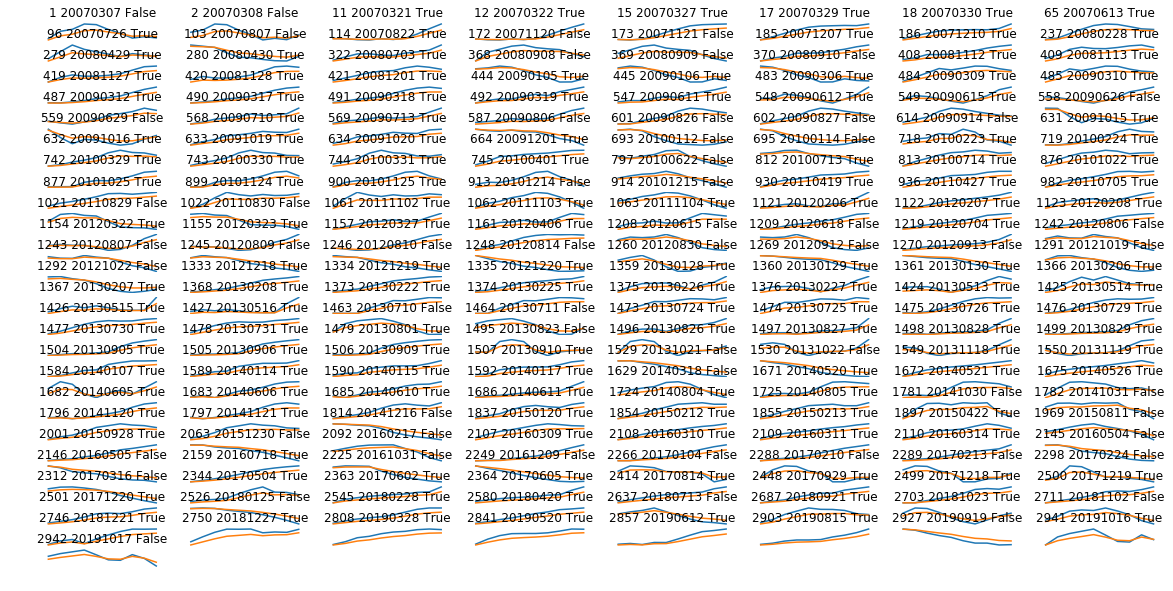

In [9]:
enter_true, enter_false, enter_discount = plot(data, golden_port)

In [10]:
enter_discount

0.7064676616915423

* MACD 优化

In [11]:
golden_port_macd = {"index":[], "date":[]}

for i in range(len(golden_port["index"])):
    index = golden_port["index"][i]
    
    if data["macd"][index] > neg_macd_mean:
        golden_port_macd["index"].append(index)
        golden_port_macd["date"].append(golden_port["date"][i])

In [12]:
len(golden_port_macd["index"])

195

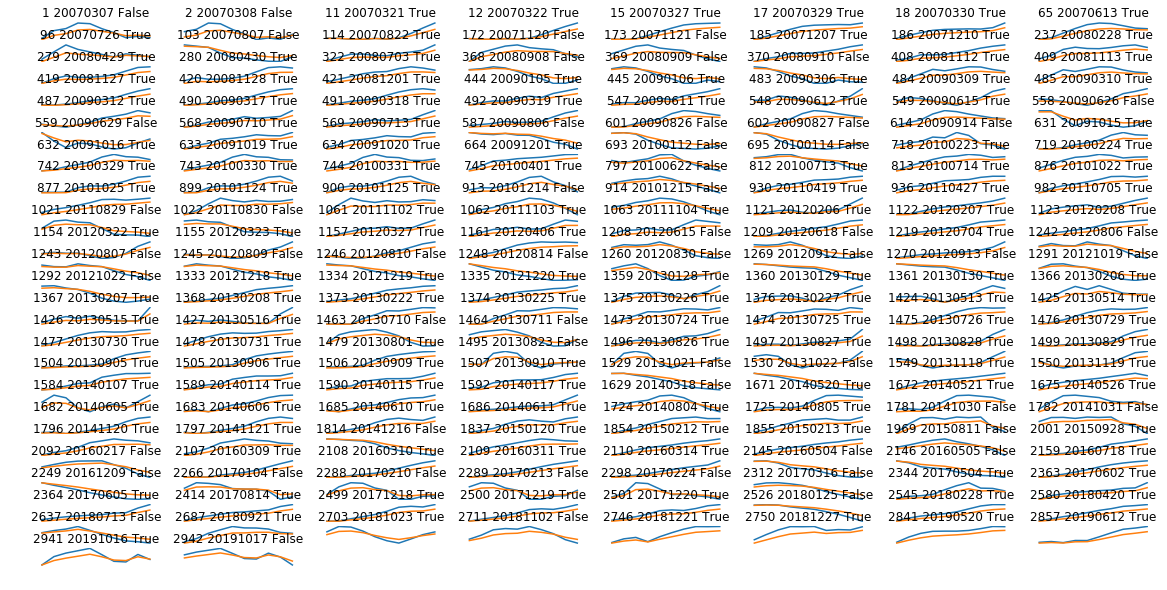

In [13]:
enter_true, enter_false, enter_discount_macd = plot(data, golden_port_macd)

In [14]:
enter_discount_macd

0.711340206185567

* dif dea 优化

In [15]:
golden_port_ddd = {"index":[], "date":[]}

for i in range(len(golden_port_macd["index"])):
    index = golden_port_macd["index"][i]
    
    if data["diff"][index] - data["dea"][index] > 0:
        if data["diff"][index] > neg_diff_mean and data["dea"][index] > neg_dea_mean:
            golden_port_ddd["index"].append(index)
            golden_port_ddd["date"].append(golden_port_macd["date"][i])

In [16]:
len(golden_port_ddd["index"])

100

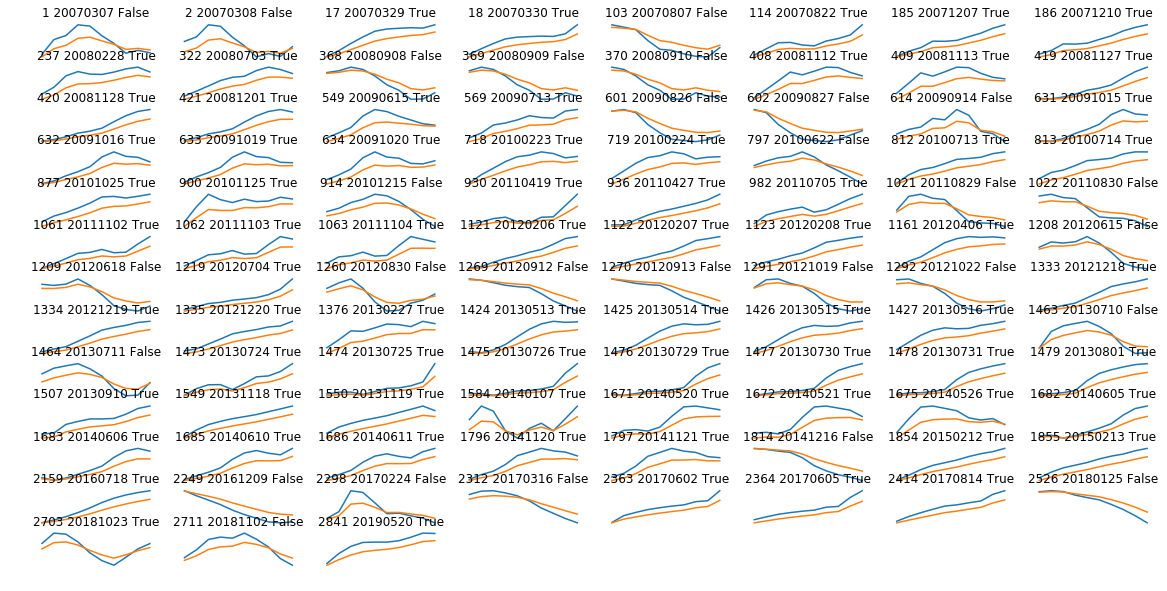

In [17]:
enter_true, enter_false, enter_discount_ddd = plot(data, golden_port_ddd)

In [18]:
enter_discount_ddd

0.7171717171717171

### TEST 2

* 获取第一个macd大于0的点

In [6]:
macd_port = {"index":[], "date":[], "data":[]}
true_count = 0

for i in range(len(data)):
    
    if data["macd"][i] > 0:
        true_count += 1
        if true_count == 1:
            macd_port["index"].append(i)
            macd_port["date"].append(data.iloc[i]['trade_date'])
            macd_port["data"].append(data.iloc[i:i+10][["ema7", "ema14"]])
    
    else:
        true_count = 0
        continue

In [7]:
len(macd_port["index"])

50

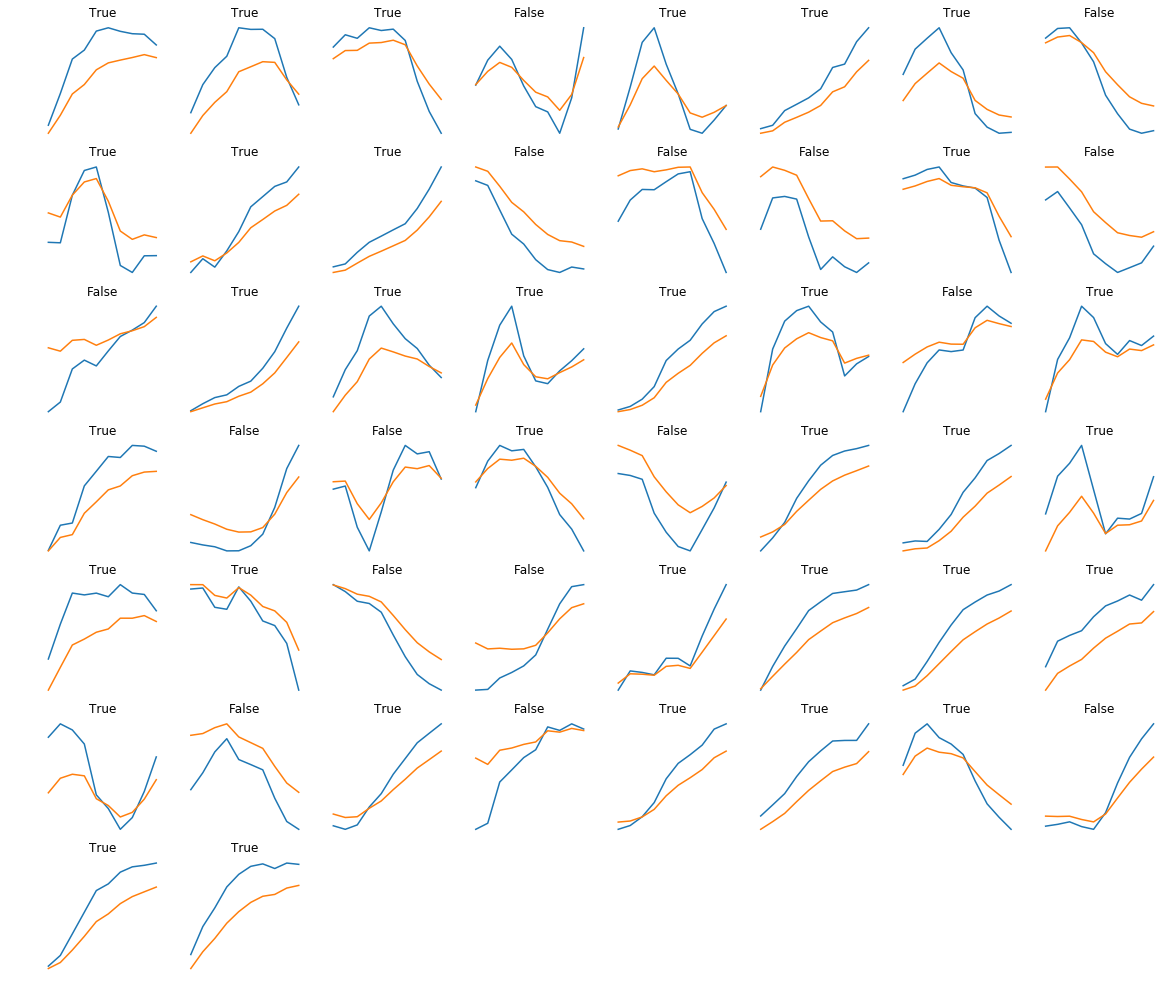

In [8]:
enter_true, enter_false, enter_discount = plot_util.plot_enter(macd_port)

In [9]:
enter_discount

0.68

* dif dea 优化

In [11]:
macd_port_ddd = {"index":[], "date":[], "data":[]}

for i in range(len(macd_port["index"])):
    index = macd_port["index"][i]
    
    if data["diff"][index] - data["dea"][index] > 0.001:
        if 0 < data["diff"][index] < pos_diff_mean and 0 < data["dea"][index] < pos_dea_mean:
            macd_port_ddd["index"].append(index)
            macd_port_ddd["date"].append(macd_port["date"][i])
            macd_port_ddd["data"].append(data.iloc[i:i+10][["ema7", "ema14"]])

In [12]:
len(macd_port_ddd["index"])

13

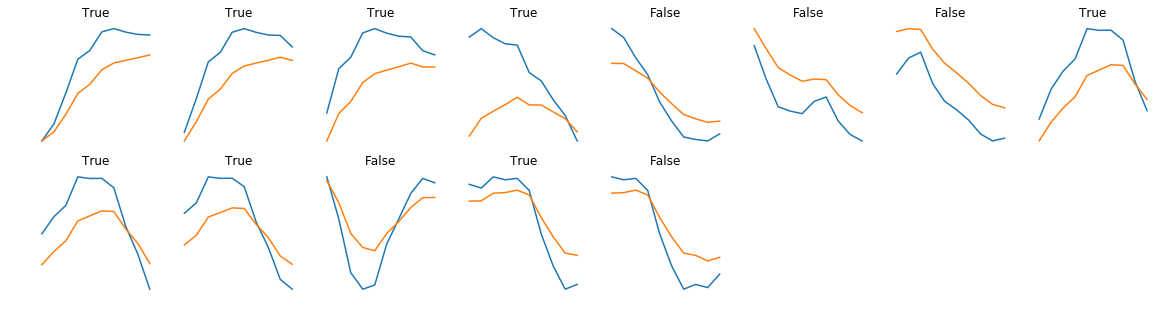

In [14]:
enter_true, enter_false, enter_discount_ddd = plot_util.plot_enter(macd_port_ddd)

In [15]:
enter_discount_ddd

0.6153846153846154